## This is a quicklook notebook where I take the target pixel file Geert Barentsen gave me and turn it into a light curve, fit some transits and search for additional planets (spoiler: I didn't find any)

In [2]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from astropy.io import fits as pyfits
from astropy.stats.funcs import median_absolute_deviation as MAD
from scipy.ndimage import label

from fit_funcs import (bg_sub, get_label_im, get_lc, transit_fit,
                       get_qf, bin_data, model_ktransit, plot_model)
import untrendy

try:
    from blssearch import doSearch, plotSearch, get_qf
    dobls = True
except ImportError:
    dofls = False

# i saved some dictionaries with planet parameters
from planet_params import *

# because I'm being sloppy
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

%matplotlib inline

In [3]:
f = pyfits.open('ktwo200164267-unofficial-tpf.fits')
data = f[1].data
print('{} cadences'.format(f[1].data['FLUX'].shape[0]))
print('pixel mask is {}'.format(f[1].data['FLUX'].shape[1:3]))

3599 cadences
pixel mask is (11, 11)


lets take a look at what the star looks like

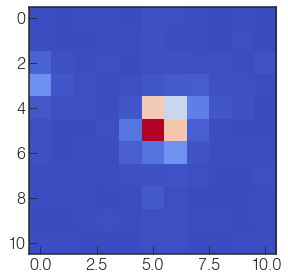

In [4]:
plt.imshow(np.sqrt(np.abs(f[1].data['FLUX'][0])), cmap='coolwarm', aspect='equal', interpolation='nearest')
plt.tight_layout()

These are some constants that I fiddled around with a found seemed to work best

In [5]:
bg_cut = 1.8
n_chunks = 7.
flatlc_window = 1.5
smooth_window = 0.6

I'm going to extract flux from the flagged pixels

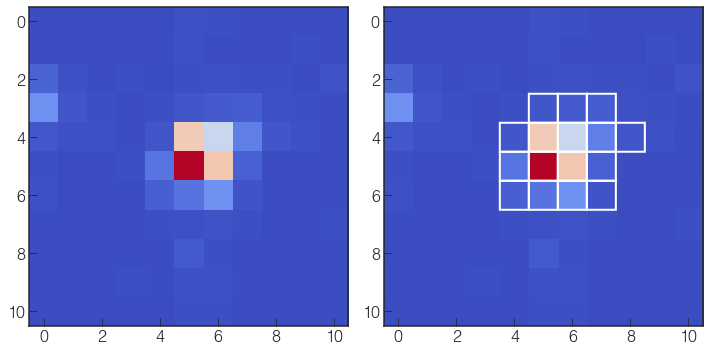

In [6]:
lab_im = get_label_im(np.copy(f[1].data['FLUX']), bg_cut)

fig, [ax1,ax] = plt.subplots(1, 2, figsize=[10,5])
ax.imshow(np.sqrt(np.abs(f[1].data['FLUX'][0])), cmap='coolwarm', aspect='equal', interpolation='nearest')
ax1.imshow(np.sqrt(np.abs(f[1].data['FLUX'][0])), cmap='coolwarm', aspect='equal', interpolation='nearest')
for i in range(11):
    for j in range(11):
        if lab_im[j,i] == 1:
            ax.add_patch(mpl.patches.Rectangle((i-.5, j-.5), 1, 1, hatch='', fill=False, snap=False, color='w', 
                                               lw=2))

plt.tight_layout()
plt.savefig('images/pixelmask.png')

I'm going to remove some cadences where we fire a thruster and remove energy from the reaction wheels, called a resat. Also, something weird happens with the pointing at the end of the campaign

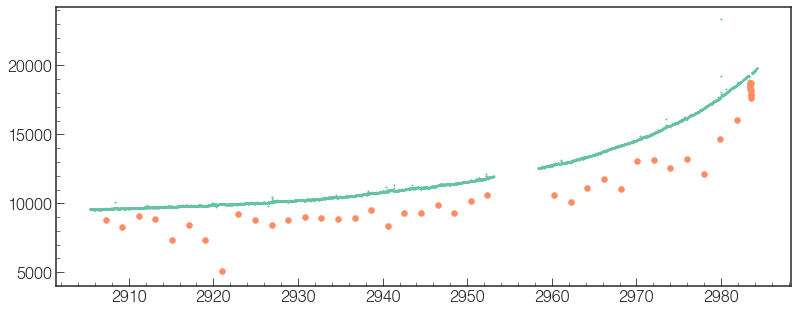

In [7]:
q1 = np.array([])
for i in np.arange(f[1].data['TIME'].shape[0]):
    q1 = np.r_[q1,np.sum(f[1].data['FLUX'][i][lab_im > 0.0])]

plt.figure(figsize=[12,5])
plt.scatter(f[1].data['TIME'],q1, s=2)

q = untrendy.median(f[1].data['TIME'],q1,dt=2)

plt.scatter(f[1].data['TIME'][(q1-q)<-500],q1[(q1-q)<-500])

badbadbad = (q1-q)<-500

plt.minorticks_on()
plt.savefig('images/rawlc.png')

ok now let's make a light curve, this uses a methods that's almost exactly like Andrew Vanderburg's

In [8]:
quality = np.zeros_like(np.copy(f[1].data['TIME']))
quality[badbadbad] = 100.
time, lc, xbar, ybar, t1, corflux, cfflux = get_lc(
    np.copy(f[1].data['TIME']), np.copy(f[1].data['FLUX']), 
    quality, n_chunks, bg_cut, flatlc_window, smooth_window)

lets make some plots
* undetrended light curve
* undetrended and the detrending model of the spots [it's a silly median filter]
* final product

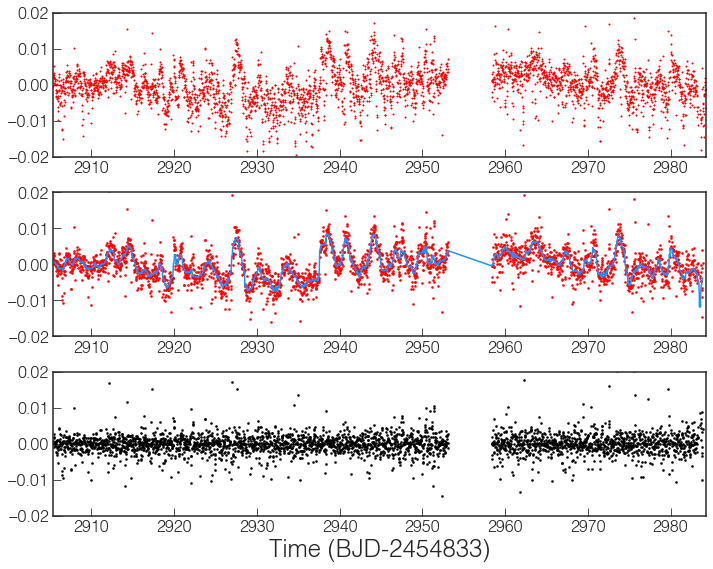

In [9]:
fig, [ax1,ax2,ax3] = plt.subplots(3, 1, figsize=[10,8])
ax1.scatter(time,lc/np.median(lc)-1.0, color='r', s=2)
ax1.set_ylim([-0.02,0.02])
ax1.set_xlim(np.min(time), np.max(time))

q = untrendy.median(t1,corflux,dt=smooth_window)
ax2.scatter(t1,corflux-1.0, color='r',s=4)
ax2.plot(t1, q-1.0, color='dodgerblue')
ax2.set_ylim([-0.02,0.02])
ax2.set_xlim(np.min(time), np.max(time))

ax3.set_ylim([-0.02,0.02])
ax3.set_xlim(np.min(time), np.max(time))
ax3.scatter(t1,cfflux, color='k',s=4)

ax3.set_xlabel('Time (BJD-2454833)')

fig.tight_layout()
plt.savefig('images/lcdetrending.png')

In [16]:
# I'm making a plot of just the middle panel because Geert wanted for the blog post

fig, ax2 = plt.subplots(1, 1, figsize=[4,8])

q = untrendy.median(t1,corflux,dt=smooth_window)
ax2.scatter(t1,corflux-1.0, color='r',s=4)
ax2.plot(t1, q-1.0, color='dodgerblue')
ax2.set_ylim([-0.02,0.02])
ax2.set_xlim(np.min(time), np.max(time))

ax3.set_xlabel('Time (BJD-2454833)')

fig.tight_layout()
plt.savefig('images/ge.png')

## hurray! let's save this data

In [10]:
outdata = np.array([t1,cfflux]).T
np.savetxt('trappist1-barclay.csv', outdata, delimiter=',',)

ok, now let's try to model the planets

In [11]:
# this can take some time, we're only only going to fit 6 planets
time, flux, fitT = transit_fit(t1, cfflux)

fitT.print_results() 

Best-fitting stellar parameters
zpt: 0.000119053954476
rho: 48.7725315837

Best-fitting planet parameters for planet 0
impact: 0.662176495657
period: 1.51100951807
T0: 7322.47509808
rprs: 0.0939323244084

Best-fitting planet parameters for planet 1
impact: 0.638969520164
period: 2.42194129986
T0: 7282.78051711
rprs: 0.0978271760163

Best-fitting planet parameters for planet 2
impact: -0.00356119571185
period: 4.05029475945
T0: 7670.13210989
rprs: 0.0618048291348

Best-fitting planet parameters for planet 3
impact: 0.586950744347
period: 6.09950981813
T0: 7660.37109219
rprs: 0.0757751546251

Best-fitting planet parameters for planet 4
impact: 0.449046086147
period: 9.20792285756
T0: 7671.3607597
rprs: 0.0739321437159

Best-fitting planet parameters for planet 5
impact: 0.795485276157
period: 12.3545208344
T0: 7665.35474277
rprs: 0.0982995763188



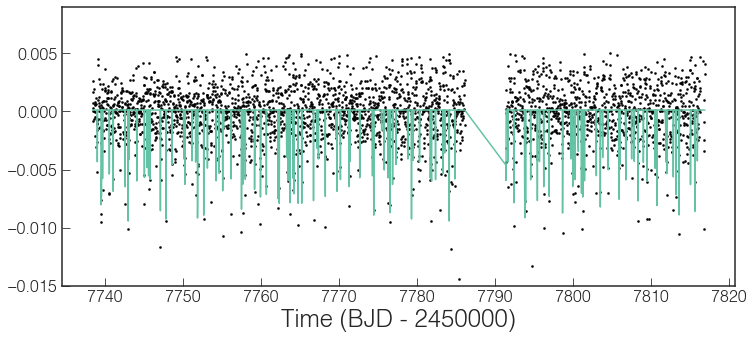

In [12]:
# here are all the transits!!
fig, ax = plt.subplots(1, 1, figsize=[11,5])
ax.scatter(time,flux, color='k',s=4)
ax.plot(time,fitT.transitmodel)
ax.set_ylim(-0.015,0.009)
ax.set_xlabel('Time (BJD - 2450000)')
plt.savefig('images/lc-with-model.png')

In [13]:
# some stellar parameters
ld1 = 0.43
ld2 = 0.14
zpt = fitT.fitresultstellar['zpt']
rho = 50.0

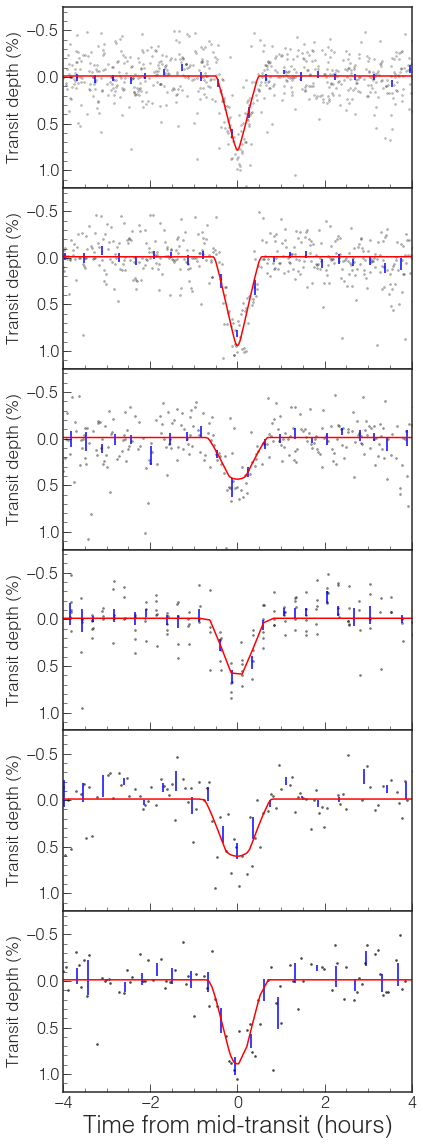

In [15]:
nplanets=6
fig, axes = plt.subplots(nplanets, 1, figsize=[6,16])
for i,p in enumerate(['pnum0','pnum1','pnum2','pnum3','pnum4','pnum5']):
    axes[i] = plot_model(axes[i],time,flux, rho, zpt, ld1, ld2, fitT.fitresultplanets[p])
    axes[i].tick_params(labelbottom=False)
axes[-1].set_xlabel('Time from mid-transit (hours)')
axes[-1].tick_params(labelbottom=True)
fig.subplots_adjust(hspace=0)
plt.tight_layout(h_pad=0)
plt.savefig('images/transitmodel.png')

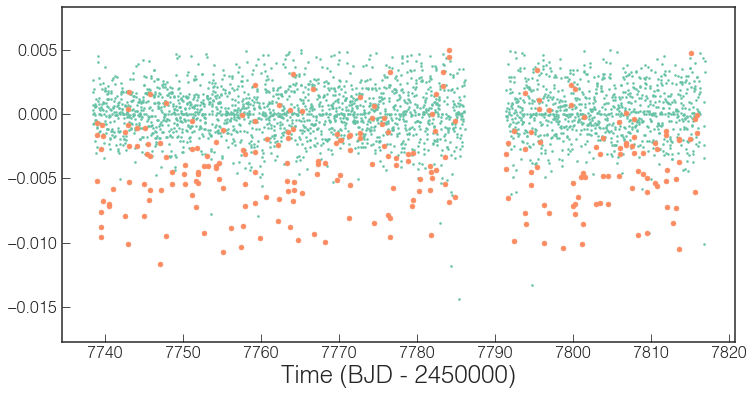

In [20]:
# data in/out of transit
fig, ax = plt.subplots(1, 1, figsize=[11,6])
ax.scatter(time[fitT.transitmodel > 0],flux[fitT.transitmodel > 0], s=4)
ax.scatter(time[fitT.transitmodel <= 0],flux[fitT.transitmodel <= 0], s=25)
ax.set_xlabel('Time (BJD - 2450000)')

### ok let's search for another planets... planet h?

In [17]:
# Main transit search
minPeriod = 13     # Limitations of BLS Fortran code
maxPeriod = 32.#(time[-1] - time[0]) /3.

# outs = doSearch(time,flux - fitT.transitmodel, minPeriod, maxPeriod, )
outs = doSearch(time[fitT.transitmodel > 0],flux[fitT.transitmodel > 0], minPeriod, maxPeriod, )

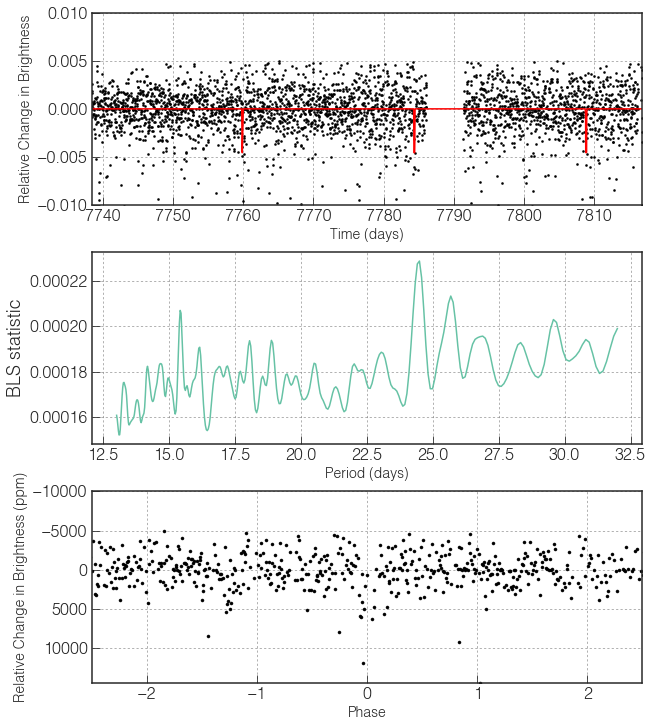

In [18]:
fig, [ax1,ax2,ax3] = plt.subplots(3,1,figsize=[9,12])
ax1.scatter(time,flux, color='k',s=4)
ax1.plot(time[fitT.transitmodel > 0], outs['transitModel'] , color='r') 
ax1.set_ylim([-0.01,0.01])
ax1.set_xlim(np.min(time), np.max(time))
ax1.set_xlabel('Time (days)', fontsize=14)
ax1.set_ylabel('Relative Change in Brightness', fontsize=14)
ax1.grid()
ax2.grid()
ax3.grid()

#ax2.plot(time, flux ) 
ax2.plot(outs['period_guesses'], outs['convolved_bls'])
ax2.set_xlabel('Period (days)', fontsize=14)
ax2.set_ylabel('BLS statistic', fontsize=18)
q,f = get_qf(time[fitT.transitmodel > 0], flux[fitT.transitmodel > 0], outs['epoch'], outs['period'])
ax3.scatter(q,f, s=9, c='k')
ax3.set_ylim([np.max(f),-10000])
#ax3.set_xlim([np.max(q),np.min(q)])
ax3.set_xlim([-2.5,2.5])
ax3.set_xlabel('Phase', fontsize=14)
ax3.set_ylabel('Relative Change in Brightness (ppm)', fontsize=14)


# this isn't very convincing, other poeple are going to do much better :)